Das angehängte CSV-File enthält Wärmezählerdaten (Arbeit, Leistung & Volumenstrom) sowie Temperatur-Sensordaten (insbes. die Außentemperatur) einer mit Fernwärme versorgten Heizungsanlage.

Die Aufgabe besteht darin, Lastprofile (Leistung gegen Zeit) über den Zeitraum eines Tages zu erstellen.

Es sollen die folgenden Fragen beantwortet werden:
1. Gibt es einen Unterschied in Lastprofilen zwischen Werktagen, Samstagen und Sonn- und Feiertagen (Das Haus befindet sich in Bayern)?

    In general, energy consumption is the highest in the morning at 6:00, and sharply decreases from 6:00 til noon around 13:00, 14:00. It slowly increases back up until 21:00, and finally reaches its bottom at around 22:00. Energy consumption on weekdays is significantly higher than Saturdays, Sundays and Holidays around 7:00 and 8:00. During working hours between 9:00 and 17:00, energy consumption on weekdays are the highest, followed by Saturdays and Sundays, and at last is Holidays. Saturdays and Sundays have nearly identical energy load profile. After working hours, all last profiles are similar, except for Holidays having slightly lower energy consumption.
    
2. Kann man aus den Daten die Heizperiode ermitteln?
    
    Heizperiode falls between start of October and end of April every year as the outside temperature decreases and the energy consumption increases reach its bottom and its top respectively on February.
    
3. Gibt es eine Nachtabsenkung während der Heizperiode?
    
    There is Nachtabsenkung as Vorlauf Temperarture 1, Rucklauf Temperature, Rucklauf 1 Temperature, Rucklauf 2 Temperature decreases by 3, 5 degrees between 21:00 and 05:00 while the outside temperature during that time is at its lowest.

In [485]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.interpolate import make_interp_spline, BSpline
import numpy as np
from pandas.tseries.holiday import Holiday, AbstractHolidayCalendar, nearest_workday
import holidays
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [496]:
# Need to remove the Arbeit record where Arbeit is 0 (broken record)

In [486]:
fields = ["Leistung [kW]", "Zeit", "Arbeit [MWh]"]

df = pd.read_csv("Trend-2021-09-09_08-02_30.csv", delimiter=";", usecols=fields)

In [487]:
df.rename(columns={'Leistung [kW]': 'Leistung', 
                   "Arbeit [MWh]": "Arbeit" }, inplace=True)

# Convert the "Leistung" column to float
df['Leistung'] = df['Leistung'].str.replace(',', '.').astype(float)
df['Arbeit'] = df['Arbeit'].str.replace(',', '.').astype(float)

# Convert the "Zeit" column to datetime
df['Zeit'] = pd.to_datetime(df['Zeit'], format='%d.%m.%Y %H:%M:%S')

In [488]:
# Set the index of the DataFrame to the "Zeit" column
df.set_index('Zeit', inplace=True)

In [474]:
# Resample the DataFrame to hourly intervals and sum the "Leistung" column for each hour
hourly_load = df.resample('H')['Leistung'].mean()

In [475]:
hourly_load

Zeit
2019-11-08 14:00:00    10.176471
2019-11-08 15:00:00     9.760000
2019-11-08 16:00:00     9.852632
2019-11-08 17:00:00    10.026316
2019-11-08 18:00:00    10.665000
                         ...    
2021-09-09 05:00:00     1.065000
2021-09-09 06:00:00    15.130000
2021-09-09 07:00:00     2.860000
2021-09-09 08:00:00     4.000000
2021-09-09 09:00:00     2.480000
Freq: H, Name: Leistung, Length: 16100, dtype: float64

In [476]:
bayern_holidays = holidays.country_holidays('DE', subdiv='BY', years=[2019, 2020, 2021])
holiday_mask = np.in1d(hourly_load.index.date, list(bayern_holidays.keys()))

In [477]:
weekday_load = hourly_load[hourly_load.index.weekday < 5]
mean_weekday_load = weekday_load.groupby(weekday_load.index.hour).mean()
saturday_load = hourly_load[hourly_load.index.weekday == 5]
mean_saturday_load = saturday_load.groupby(saturday_load.index.hour).mean()
sunday_load = hourly_load[hourly_load.index.weekday == 6]
mean_sunday_load = sunday_load.groupby(sunday_load.index.hour).mean()
holiday_load = hourly_load[holiday_mask]
mean_holiday_load = holiday_load.groupby(holiday_load.index.hour).mean()

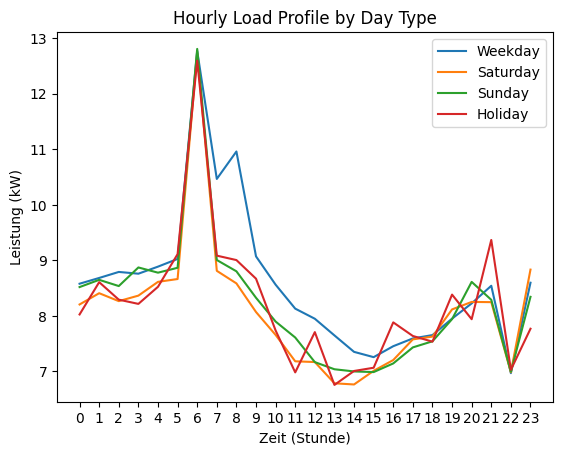

In [479]:
# Create the line graph
plt.plot(mean_weekday_load, label='Weekday')
plt.plot(mean_saturday_load, label='Saturday')
plt.plot(mean_sunday_load, label='Sunday')
plt.plot(mean_holiday_load, label='Holiday')

# Set the x-axis labels
plt.xticks(range(0, 24))

# Add a title and labels for the x and y axes
plt.title('Hourly Load Profile by Day Type')
plt.xlabel('Zeit (Stunde)')
plt.ylabel('Leistung (kW)')

# Add a legend
plt.legend()

# Display the graph
plt.show()

In [128]:
# # Convert the data into a long format suitable for Plotly Express
# df_plot = pd.concat([mean_weekday_load, mean_saturday_load, mean_sunday_load], axis=1)
# df_plot.columns = ['Weekday', 'Saturday', 'Sunday']
# df_plot = df_plot.reset_index().melt(id_vars='Zeit', var_name='Day Type', value_name='Energy Consumption (kW)')

# # Create the line graph with Plotly Express
# fig = px.line(df_plot, x='Zeit', y='Energy Consumption (kW)', color='Day Type')

# # Add a title and labels for the x and y axes
# fig.update_layout(title='Hourly Load Profile by Day Type', xaxis_title='Time', yaxis_title='Energy Consumption (kW)')

# # Display the graph
# fig.show()

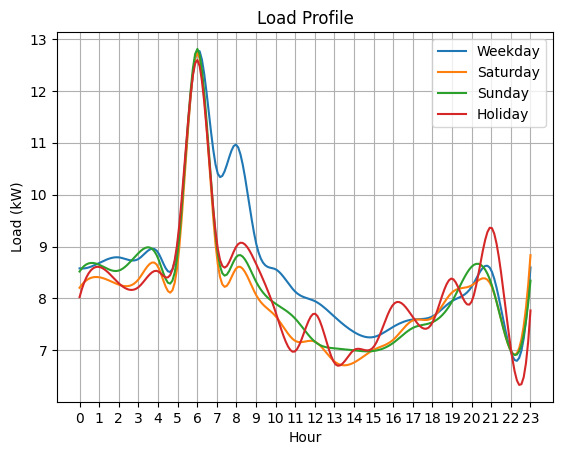

In [480]:
# Create a smoother line
xnew = np.linspace(0, 23, 200)  # 300 represents number of points to make between T.min and T.max
spl = make_interp_spline(mean_weekday_load.index, mean_weekday_load, k=3)  # type: BSpline
power_smooth = spl(xnew)
plt.plot(xnew, power_smooth)

spl = make_interp_spline(mean_saturday_load.index, mean_saturday_load, k=3)  # type: BSpline
power_smooth = spl(xnew)
plt.plot(xnew, power_smooth)

spl = make_interp_spline(mean_sunday_load.index, mean_sunday_load, k=3)  # type: BSpline
power_smooth = spl(xnew)
plt.plot(xnew, power_smooth)

spl = make_interp_spline(mean_sunday_load.index, mean_holiday_load, k=3)  # type: BSpline
power_smooth = spl(xnew)
plt.plot(xnew, power_smooth)

# Set the x-axis labels
plt.xticks(range(0, 24))

# Add labels to the axes
plt.xlabel('Hour')
plt.ylabel('Load (kW)')
plt.title('Load Profile')

plt.grid(True)

# Add a legend
plt.legend(['Weekday', 'Saturday', 'Sunday', 'Holiday'])

In [498]:
fields = ["Leistung [kW]", "Außentemperatur [°C]", "Zeit"]

df = pd.read_csv("Trend-2021-09-09_08-02_30.csv", delimiter=";", usecols=fields)

In [499]:
df.rename(columns={'Leistung [kW]': 'Leistung', 'Außentemperatur [°C]': 'Außentemperatur'}, inplace=True)

# Convert the "Leistung" column to float
df['Leistung'] = df['Leistung'].str.replace(',', '.').astype(float)

# Convert the "Außentemperatur" column to float
df['Außentemperatur'] = df['Außentemperatur'].str.replace(',', '.').astype(float)

# Convert the "Zeit" column to datetime
df['Zeit'] = pd.to_datetime(df['Zeit'], format='%d.%m.%Y %H:%M:%S')

# Set the index of the DataFrame to the "Zeit" column
df.set_index('Zeit', inplace=True)

In [308]:
# # Group the DataFrame by the date and calculate the mean of the 'Außentemperatur' column
# daily_temp = df.groupby(df.index.date)['Außentemperatur'].mean()

# # Plot the data
# plt.plot(daily_temp.index, daily_temp.values)
# plt.xlabel('Date')
# plt.ylabel('Average Temperature [°C]')
# plt.title('Average Temperature per Day')
# plt.show()

In [307]:
# # Group the DataFrame by the date and calculate the mean of the 'Außentemperatur' column
# daily_load = df.groupby(df.index.date)['Leistung'].sum()

# # Plot the data
# plt.plot(daily_load.index, daily_load.values)
# plt.xlabel('Date')
# plt.ylabel('Average Load [kW]')
# plt.title('Average Load per Day')
# plt.show()

In [507]:
df.groupby(pd.Grouper(freq='M'))

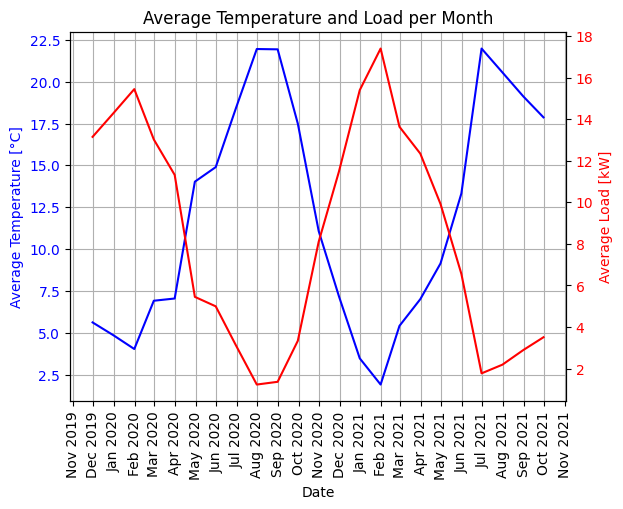

In [509]:
# Create figure and axes objects
fig, ax1 = plt.subplots()

# Group the DataFrame by the month and calculate the mean of the 'Außentemperatur' column
monthly_temp = df.groupby(pd.Grouper(freq='M'))['Außentemperatur'].mean()

# Plot the data on the first axis
ax1.plot(monthly_temp.index, monthly_temp.values, color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Temperature [°C]', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Average Temperature and Load per Month')

plt.xticks(rotation=90)

# Add a second axis for the load data
ax2 = ax1.twinx()

# Group the DataFrame by the month and calculate the mean of the 'Leistung' column
monthly_load = df.groupby(pd.Grouper(freq='M'))['Leistung'].mean()

# Plot the data on the second axis
ax2.plot(monthly_load.index, monthly_load.values, color='red')
ax2.set_ylabel('Average Load [kW]', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add x-axis ticks for all months
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax1.grid(True)

plt.show()

In [510]:
# Get data between the first of October and the end of April every year
heating_season_mask = ((hourly_load.index.month >= 10) | (hourly_load.index.month <= 4))
heating_season_load = hourly_load[heating_season_mask]
heating_season_holiday_mask = np.in1d(heating_season_load.index.date, list(bayern_holidays.keys()))

In [511]:
heating_season_weekday_load = heating_season_load[heating_season_load.index.weekday < 5]
heating_season_mean_weekday_load = heating_season_weekday_load.groupby(heating_season_weekday_load.index.hour).mean()
heating_season_saturday_load = heating_season_load[heating_season_load.index.weekday == 5]
heating_season_mean_saturday_load = heating_season_saturday_load.groupby(heating_season_saturday_load.index.hour).mean()
heating_season_sunday_load = heating_season_load[heating_season_load.index.weekday == 6]
heating_season_mean_sunday_load = heating_season_sunday_load.groupby(heating_season_sunday_load.index.hour).mean()
heating_season_holiday_load = heating_season_load[heating_season_holiday_mask]
heating_season_mean_holiday_load = heating_season_holiday_load.groupby(heating_season_holiday_load.index.hour).mean()

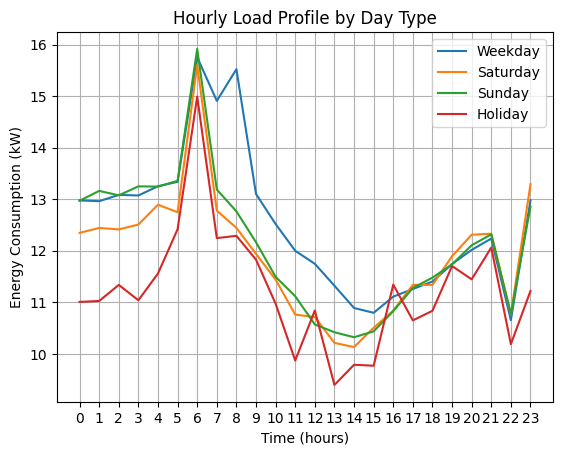

In [512]:
# Create the line graph
plt.plot(heating_season_mean_weekday_load, label='Weekday')
plt.plot(heating_season_mean_saturday_load, label='Saturday')
plt.plot(heating_season_mean_sunday_load, label='Sunday')
plt.plot(heating_season_mean_holiday_load, label='Holiday')

# Set the x-axis labels
plt.xticks(range(0, 24))

# Add a title and labels for the x and y axes
plt.title('Hourly Load Profile by Day Type')
plt.xlabel('Time (hours)')
plt.ylabel('Energy Consumption (kW)')

# Add a legend
plt.legend()

plt.grid(True)

# Display the graph
plt.show()

In [346]:
# Get data between the first of October and the end of April every year
non_heating_season_mask = ((hourly_load.index.month < 10) & (hourly_load.index.month > 4))
non_heating_season_load = hourly_load[non_heating_season_mask]
non_heating_season_holiday_mask = np.in1d(non_heating_season_load.index.date, list(bayern_holidays.keys()))

In [347]:
non_heating_season_weekday_load = non_heating_season_load[non_heating_season_load.index.weekday < 5]
non_heating_season_mean_weekday_load = non_heating_season_weekday_load.groupby(non_heating_season_weekday_load.index.hour).mean()
non_heating_season_saturday_load = non_heating_season_load[non_heating_season_load.index.weekday == 5]
non_heating_season_mean_saturday_load = non_heating_season_saturday_load.groupby(non_heating_season_saturday_load.index.hour).mean()
non_heating_season_sunday_load = non_heating_season_load[non_heating_season_load.index.weekday == 6]
non_heating_season_mean_sunday_load = non_heating_season_sunday_load.groupby(non_heating_season_sunday_load.index.hour).mean()
non_heating_season_holiday_load = non_heating_season_load[non_heating_season_holiday_mask]
non_heating_season_mean_holiday_load = non_heating_season_holiday_load.groupby(non_heating_season_holiday_load.index.hour).mean()

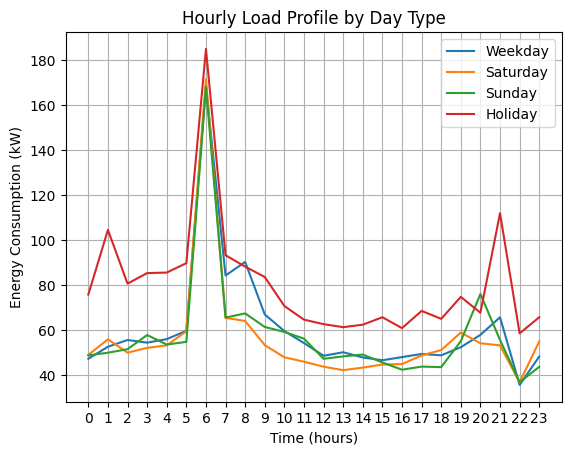

In [348]:
# Create the line graph
plt.plot(non_heating_season_mean_weekday_load, label='Weekday')
plt.plot(non_heating_season_mean_saturday_load, label='Saturday')
plt.plot(non_heating_season_mean_sunday_load, label='Sunday')
plt.plot(non_heating_season_mean_holiday_load, label='Holiday')

# Set the x-axis labels
plt.xticks(range(0, 24))

# Add a title and labels for the x and y axes
plt.title('Hourly Load Profile by Day Type')
plt.xlabel('Time (hours)')
plt.ylabel('Energy Consumption (kW)')

# Add a legend
plt.legend()

plt.grid(True)

# Display the graph
plt.show()

In [402]:
fields = ["Leistung [kW]", "Außentemperatur [°C]", "Zeit", "Prim. Vorlauf [°C]",
         "Prim. Rücklauf [°C]", "Rücklauf 1 [°C]", "Rücklauf 2 [°C]", "Vorlauf 1 [°C]"]

df = pd.read_csv("Trend-2021-09-09_08-02_30.csv", delimiter=";", usecols=fields)

In [403]:
df.rename(columns={'Leistung [kW]': 'Leistung', 'Außentemperatur [°C]': 'Außentemperatur', 
                  "Prim. Vorlauf [°C]": "Prim. Vorlauf", 
                  "Prim. Rücklauf [°C]": "Prim. Rücklauf", 
                  "Rücklauf 1 [°C]": "Rücklauf 1", 
                  "Rücklauf 2 [°C]": "Rücklauf 2", 
                  "Vorlauf 1 [°C]": "Vorlauf 1"}, inplace=True)

In [404]:
# Convert the "Leistung", "Außentemperatur" column to float
df['Leistung'] = df['Leistung'].str.replace(',', '.').astype(float)
df['Außentemperatur'] = df['Außentemperatur'].str.replace(',', '.').astype(float)
df['Rücklauf 1'] = df['Rücklauf 1'].str.replace(',', '.').astype(float)
df['Rücklauf 2'] = df['Rücklauf 2'].str.replace(',', '.').astype(float)
df['Vorlauf 1'] = df['Vorlauf 1'].str.replace(',', '.').astype(float)

# Convert the "Zeit" column to datetime
df['Zeit'] = pd.to_datetime(df['Zeit'], format='%d.%m.%Y %H:%M:%S')
df.set_index('Zeit', inplace=True)

In [406]:
df = df.loc[(df.index.month >= 10) | (df.index.month <= 4)]

In [407]:
# Resample the DataFrame to hourly intervals
hourly_data = df.resample('H').mean()

In [408]:
mean_vorlauf_temp = hourly_data['Prim. Vorlauf'].groupby(hourly_data.index.hour).mean()
mean_rucklauf_temp = hourly_data['Prim. Rücklauf'].groupby(hourly_data.index.hour).mean()
mean_outside_temp = hourly_data['Außentemperatur'].groupby(hourly_data.index.hour).mean()
mean_rucklauf_1_temp = hourly_data['Rücklauf 1'].groupby(hourly_data.index.hour).mean()
mean_rucklauf_2_temp = hourly_data['Rücklauf 2'].groupby(hourly_data.index.hour).mean()
mean_vorlauf_1_temp = hourly_data['Vorlauf 1'].groupby(hourly_data.index.hour).mean()

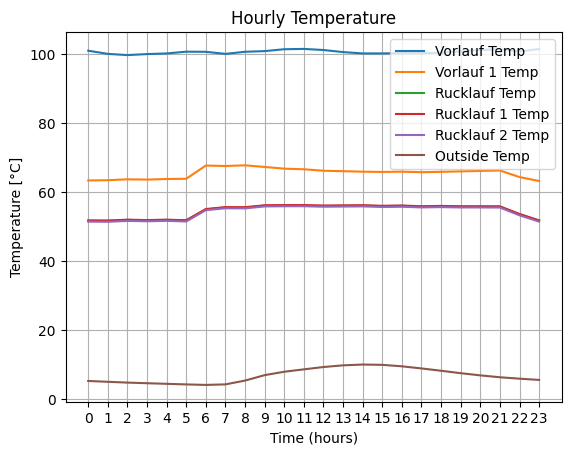

In [426]:
# Create the line graph
plt.plot(mean_vorlauf_temp, label='Vorlauf Temp')
plt.plot(mean_vorlauf_1_temp, label='Vorlauf 1 Temp')
plt.plot(mean_rucklauf_temp, label='Rucklauf Temp')
plt.plot(mean_rucklauf_1_temp, label='Rucklauf 1 Temp')
plt.plot(mean_rucklauf_2_temp, label='Rucklauf 2 Temp')
plt.plot(mean_outside_temp, label='Outside Temp')

# Set the x-axis labels
plt.xticks(range(0, 24))

# Add a title and labels for the x and y axes
plt.title('Hourly Temperature')
plt.xlabel('Time (hours)')
plt.ylabel('Temperature [°C]')

# Add a legend
plt.legend()

plt.grid(True)

# Display the graph
plt.show()

In [399]:
df = pd.read_csv("Trend-2021-09-09_08-02_30.csv", delimiter=";")
df = df.dropna(axis=1)


/var/folders/vs/_r7c0zhs07g_2l34drz17qgh0000gn/T/ipykernel_45964/446759602.py:1: DtypeWarning:

Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.



In [400]:
temp_cols = [col for col in df.columns if col.endswith("[°C]")]

df[temp_cols]

,Prim. Vorlauf [°C],Prim. Rücklauf [°C],Außentemperatur [°C],Rücklauf 1 [°C],Rücklauf 2 [°C],Vorlauf 1 [°C]
0,100,60,"7,8","60,2","59,9",63
1,100,60,"7,9","59,7","59,3","62,4"
2,100,60,"7,8","59,6","59,3","62,3"
3,100,59,"7,9","59,6","59,2","62,3"
4,101,60,"7,9","59,6","59,3","62,4"
...,...,...,...,...,...,...
313928,86,61,"24,2","47,1","46,4","57,6"
313929,92,47,"24,5","46,7","46,4","54,5"
313930,93,46,"24,8","46,7","46,4","53,8"
313931,92,46,25,"46,4","46,2","64,7"
